<a href="https://colab.research.google.com/github/NovakMateusz/crispy-sentiment-ml/blob/master/notebooks/IMDB%20/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Model selection

In [ ]:
!pip install boto3
!pip install scikit-learn==1.2.1

import datetime
import pathlib
import pickle
import uuid
import os

import boto3
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


plt.rcParams["figure.figsize"] = (16, 8)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


### Mounting Google Drive and setting up paths

In [ ]:
drive.mount('/content/drive')

COLAB_ROOT_DIR = pathlib.Path('.')
DRIVE_ROOT_DIR = COLAB_ROOT_DIR / 'drive/MyDrive'
PROJECT_ROOT_DIR = DRIVE_ROOT_DIR / 'bachelors_dissertation'

DATA_DIR = PROJECT_ROOT_DIR / 'data' / 'clean' / 'IMDB'
MODELS_DIR = PROJECT_ROOT_DIR / 'models'

Mounted at /content/drive


### Constans

In [ ]:
LABELS = {
    0: 'Negative',
    1: 'Positive'
}

BUCKET_NAME = 'crispy-sentiment'
TENANT = 'en'

### Load the dataset

In [ ]:
dataframe = pd.read_csv(DATA_DIR / 'IMDB_50K_clean.csv')

### Split dataset to train and test sets

In [ ]:
%%time

train_set, test_set = train_test_split(dataframe, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(stop_words='english')

train_set_vector = vectorizer.fit_transform(train_set['text'])
test_set_vector = vectorizer.transform(test_set['text'])

CPU times: user 10.1 s, sys: 77.5 ms, total: 10.1 s
Wall time: 10.2 s


### SGD Classifier

In [ ]:
%%time
sgd_model = SGDClassifier()
sgd_model.fit(train_set_vector, train_set['label'])

CPU times: user 1.46 s, sys: 31.4 ms, total: 1.49 s
Wall time: 4.42 s


SGDClassifier()

In [ ]:
train_labels_predictions = cross_val_predict(sgd_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.840
recall:		0.840
f1:		0.840


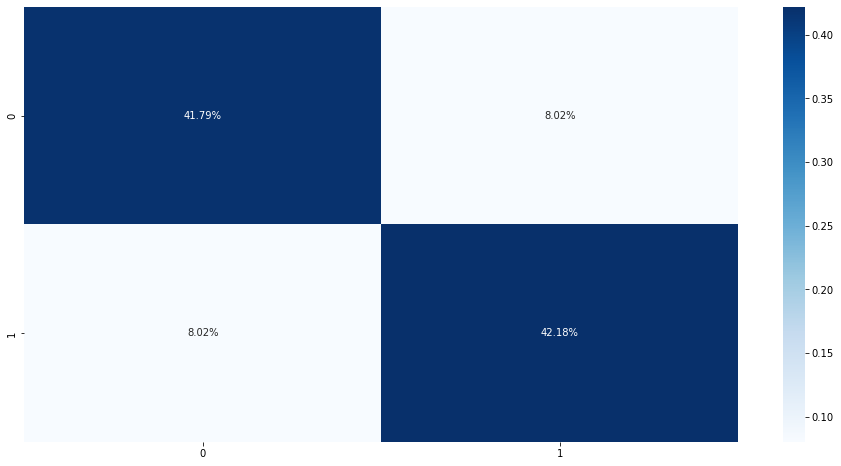

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Logistic Regression Classifier

In [ ]:
%%time

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_set_vector, train_set['label'])

CPU times: user 23.2 s, sys: 24.1 s, total: 47.4 s
Wall time: 44.5 s


LogisticRegression(max_iter=1000)

In [ ]:
train_labels_predictions = cross_val_predict(lr_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.848
recall:		0.867
f1:		0.858


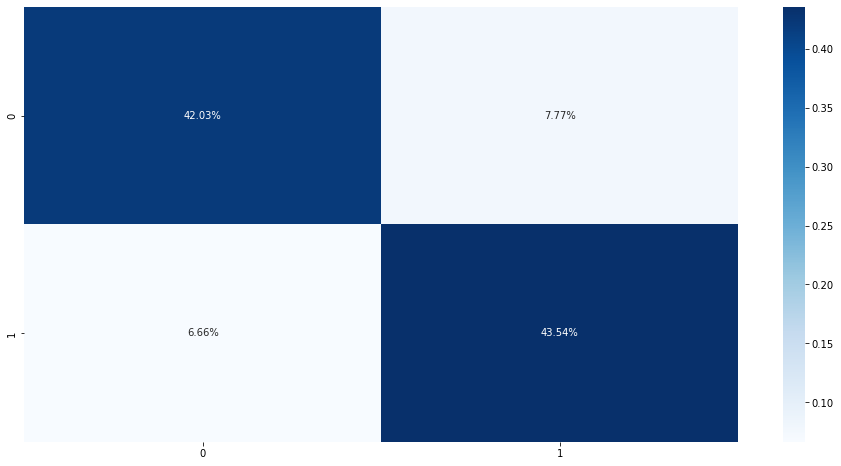

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Decision Tree Classifier

In [ ]:
%%time

model = DecisionTreeClassifier()
model.fit(train_set_vector, train_set['label'])

CPU times: user 1min 36s, sys: 2.12 ms, total: 1min 36s
Wall time: 1min 38s


DecisionTreeClassifier()

In [ ]:
train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.712
recall:		0.712
f1:		0.712


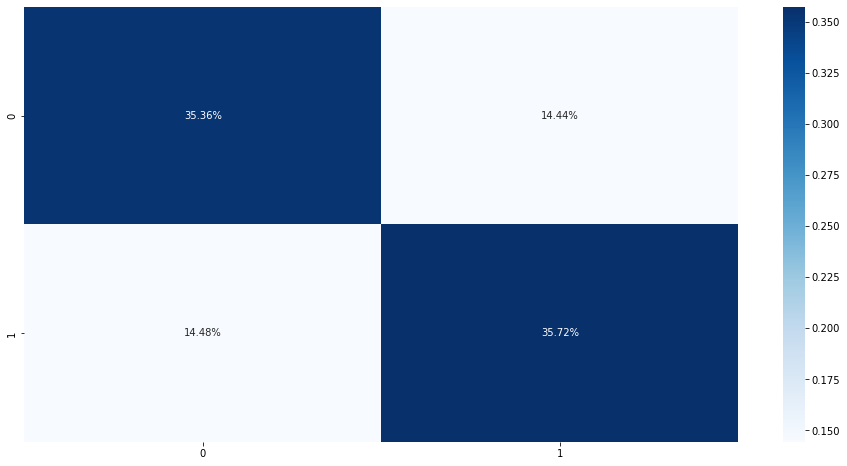

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Hyperparameter tuning of Logistic Regression model

In [ ]:
model = LogisticRegression(max_iter=1000)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1.0, 0.5, 0.1, 0.01, 0.001]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic_regression_grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=2, scoring='f1', verbose=3)
logistic_regression_grid_search.fit(train_set_vector, train_set['label']);

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.877 total time=  10.6s
[CV 2/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.872 total time=   7.4s
[CV 1/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.877 total time=  14.2s
[CV 2/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.872 total time=  12.2s
[CV 1/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.877 total time=   6.3s
[CV 2/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.872 total time=   5.2s
[CV 1/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.880 total time=   7.0s
[CV 2/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.875 total time=  11.6s
[CV 1/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.880 total time=  13.4s
[CV 2/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.875 total time=  11.7s
[CV 1/2] END C=0.5, penalty=l2, solver=liblinear;, score=0.880 total time=   3.5s
[CV 2/2] END C=0.5, penalty=l2, solver=li

In [ ]:
print(logistic_regression_grid_search.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
model = LogisticRegression(max_iter=1000, **logistic_regression_grid_search.best_params_)
model.fit(train_set_vector, train_set['label']);

train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

precision = precision_score(test_set['label'], train_labels_predictions)
recall = recall_score(test_set['label'], train_labels_predictions)
f1 = f1_score(test_set['label'], train_labels_predictions)

print('precision:\t%.3f' % precision)
print('recall:\t\t%.3f' % recall)
print('f1:\t\t%.3f' % f1)

precision:	0.853
recall:		0.874
f1:		0.864


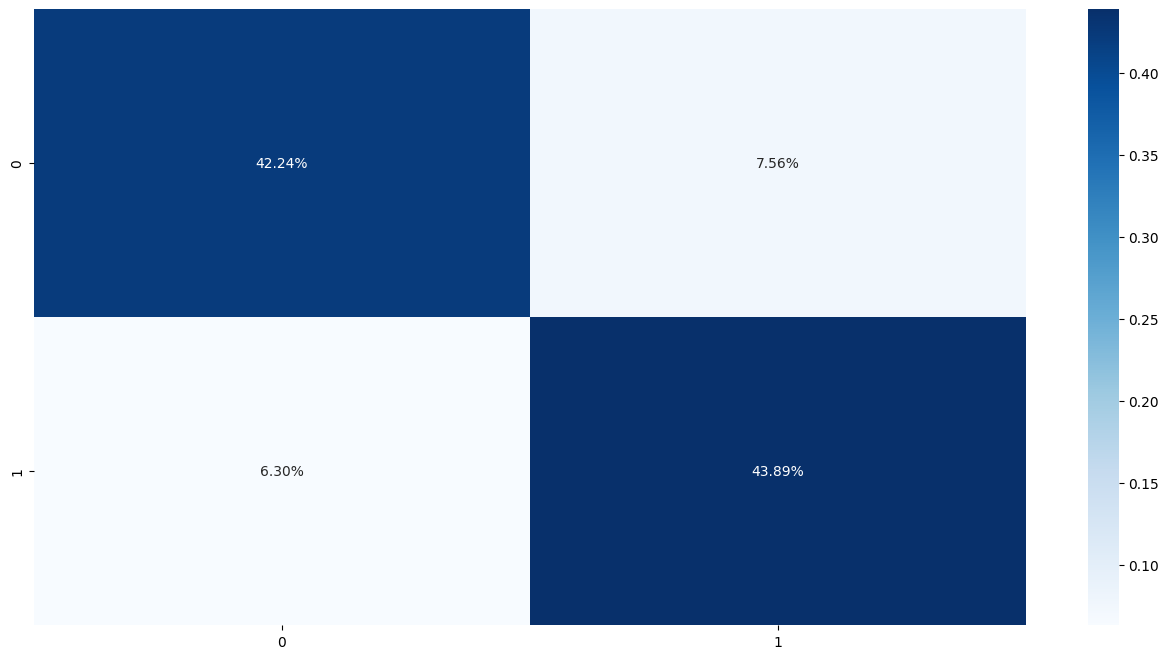

In [ ]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Saving the best model on Google Drive


In [ ]:
save_date = datetime.datetime.now().strftime("%Y%m%d")
model_name = 'logistic_regression'
model_hash = uuid.uuid4().hex

output = {
    "model_name": model_name,
    'model_hash': model_hash,
    'labels': LABELS,
    "model": model,
    "vectorizer": vectorizer,
    'metrics': {
        'precision': precision,
        'recall': recall,
        'f1': f1,
      },
    'documentation': {
        'model': {
            'text': 'This type of statistical model (also known as logit model) is often used for classification and predictive analytics. Logistic regression estimates the probability of an event occurring, such as voted or didn’t vote, based on a given dataset of independent variables. Since the outcome is a probability, the dependent variable is bounded between 0 and 1. In logistic regression, a logit transformation is applied on the odds—that is, the probability of success divided by the probability of failure.',
            'source': 'https://www.ibm.com/topics/logistic-regression'
        },
        'precision': {
            'text': 'A measurement that specifies how many mentions that should have been annotated by a given label were actually annotated with that label - the right mentions being those that human annotators identified in the same documents. Recall is determined by the number of correctly labeled annotations divided by the number of annotations that should have been created. A recall score of 1.0 means that every mention that should have been labeled as entity type A was labeled correctly. A low recall score helps you identify places where the machine learning model failed to create an annotation that it should have. The score says nothing about how many other mentions were also labeled as entity type A, but should not have been; the precision score reflects that information.',
            'source': 'https://cloud.ibm.com/docs/watson-knowledge-studio?topic=watson-knowledge-studio-evaluate-ml'
        },
        'recall': {
            'text': "A measurement that specifies what fraction of the machine learning model's output was accurate when compared to the human annotator output. Precision is determined by the number of correctly labeled annotations divided by the total number of annotations added by the machine learning model. A precision score of 1.0 for entity type A means that every mention that was labeled as entity type A does indeed belong to that classification. A low precision score helps you identify places where the machine learning model created incorrect annotations. The score says nothing about how many other mentions that were labeled as entity type A by the human annotator were missed by the machine learning model; the recall score reflects that information.",
            'source': 'https://cloud.ibm.com/docs/watson-knowledge-studio?topic=watson-knowledge-studio-evaluate-ml'
        },
        'f1': {
            'text': 'A measurement that considers both precision and recall to compute the score. The F1 score can be interpreted as a weighted average of the precision and recall values, where an F1 score reaches its best value at 1 and worst value at 0.',
            'source': 'https://cloud.ibm.com/docs/watson-knowledge-studio?topic=watson-knowledge-studio-evaluate-ml'
        }

    }
    }

with open(MODELS_DIR / f'{model_name}_{save_date}', 'wb') as fp:
  pickle.dump(output, fp)

### Saving the best model on Filebase

In [ ]:
s3_client = boto3.client('s3', endpoint_url='https://s3.filebase.com', aws_access_key_id=os.getenv('filebase_access_key_id'), aws_secret_access_key=os.getenv('filebase_secret_access_key'))


with open(MODELS_DIR / f'{model_name}_{save_date}', 'rb') as fp:
  s3_client.upload_fileobj(fp, BUCKET_NAME, f'{TENANT}/{model_hash}')

### Final model description

In [ ]:
print('General info')
print(f'\tModel name:\t{model_name}')
print(f'\tModel hash:\t{model_hash}')
print(f'\tDate:\t\t{datetime.datetime.now()}')
print("Metrics")
print(f'\tPrecision:\t{precision}')
print(f'\tRecall:\t\t{recall}')
print(f'\tf1: \t\t{f1}')

General info
	Model name:	logistic_regression
	Model hash:	7752d53ec8fa41eea7fca02e31228ff1
	Date:		2023-08-22 20:21:30.951840
Metrics
	Precision:	0.8530276308054086
	Recall:		0.8744475693049417
	f1: 		0.8636048011110009


### Test model on sample review

In [ ]:
example_review = "Horrible, horrible, horrible I can't believe how miscast this movie is. What was Ed Norton thinking when he signed up for this? Okay, it's a remake. If you saw the first hulk, you don't need to see this one. Feel free to avoid this one. And feel happy that you did."

text_string = vectorizer.transform([example_review])
print(LABELS[model.predict(text_string)[0]])

Negative
